In this lesson, we will use a finite-volume method to create a solution using godunov's method to solve the issue of Riemann problems within our solutions.

In [1]:
import numpy as ny
from matplotlib import pyplot as py
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

In [3]:
from traffic import rho_red_light, flux

In [4]:
# now we can set our parameters based on the functions
# that we downloaded from the file titled traffic

In [5]:
nx = 100 # number of cells along road
L = 4.0 # length of road
dx = L / nx # width of cell on road
nt = 30 # number of time steps
rho_max = 10.0 # max traffic density
u_max =1.0 #speed limit

# center the grid cells
# x_i is now the center of the ith cell
x = ny.linspace(0.0 +0.5 * dx, L- 0.5 * dx, num=nx)

# compute initial traffic density
rho0 = rho_red_light(x, rho_max)

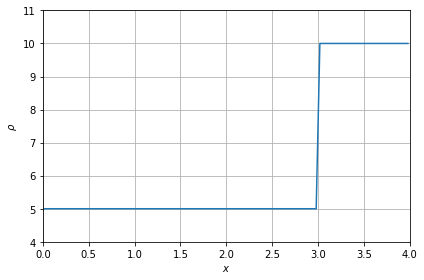

In [7]:
# plot initial car density on road
fig = py.figure(figsize=(6.0, 4.0))
py.xlabel(r'$x$')
py.ylabel(r'$\rho$')
py.grid()
line = py.plot(x, rho0)[0]
py.xlim(0.0, L)
py.ylim(4.0, 11.0)
py.tight_layout();

The following function that applies Godunov's method with Lax-Friedrichs fluxes.

In [8]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        rhoL = rho[:-1] # i-th value at index i-1/2
        rhoR = rho[1:] # i+1-th value at index i-1/2
        
        #compute flux at cell boundaries
        
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) -
                  dx / dt * (rhoR - rhoL))
        
        #advancing in time
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        
        #apply boundary conditions
        rho[0], rho[-1] = bc_values
        
        #saving the time-step solution
        rho_hist.append(rho.copy())
    return rho_hist

In [9]:
# set time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max #time-step size

# compute traffic density at all time steps
rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                  u_max, rho_max)

In [10]:
def update_plot(n, rho_hist):
    
    fig.suptitle('time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [11]:
anim= animation.FuncAnimation(fig, update_plot,
                             frames=nt, fargs=(rho_hist,),
                             interval=100)

# display video
HTML(anim.to_html5_video())

MUSCL schemes

This next function will define the minmod concept, which defines the e values based on the slope of the function around shocks.

In [12]:
def minmod(e, dx):
    
    sigma = ny.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i-1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
    return sigma

In [ ]:
def muscl(rho0, nt, dt, dx, bc_values, *args):
    
    def compute_flux(rho):
        # compute minmod slope
        sigma = minmod(rho, dx)
        
        #reconstruct values at cell boundaries
        
        rhoL = (rho + sigma * dx / 2.0)[:-1]